# Principal Component Analysis on the Iris dataset

### Preparations

In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Unsupervised learning: PCA, K-means clustering, agglomerative clustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

### Functions

In [ ]:
def show_distributions(df, target):
    '''
    Function to show variable distribution histograms and boxplots against 
    the target variable.
    Parameters:
       df = dataframe of variables
       target = column name of the target variable, entered as "column"
    '''
    # Create list of columns, excluding the target variable
    col_ls = df.columns.tolist()
    col_ls.remove(target)

    # Loop through the columns to create the plots for each variable
    for col in col_ls:
        # Prepare the figure
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
        # Histogram for each feature
        sns.histplot(df[col], bins=20, kde=True, ax=axes[0])
        axes[0].set_title(f"Distribution of {col}")
    
        # Boxplots showing feature distribution by target
        sns.boxplot(
            x=target, y=col, data=df, 
            hue=target, legend=False, palette='Dark2'
        )
        axes[1].set_title(f"{col} by {target}")
    
        plt.tight_layout()

In [ ]:
def outliers_by_IQR(df, target):
    '''
    Identifies and returns outliers by the IQR method. Outliers are outside 
    the lower and upper bounds, where the lower bound = Q1 - 1.5IQR and the 
    upper bound = Q3 + 1.5IQR.
    Parameters:
        df = dataframe of variables
        target = column name of the target variable, entered as "column"
    Output:
        outliers_ls = list containing the outlier entries in df. outliers_ls[0] 
        contains the column names. outliers_ls[1] contains a dataframe of the 
        outliers, so that is returned.
    '''
    # Create list of columns, excluding the target variable
    col_ls = df.columns.tolist()
    col_ls.remove(target)
    
    # Create empty list to build into the output
    outliers_ls = []

    # Loop through the columns to find outliers
    for col in col_ls:
        # Calculate interquartile range (IQR)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
    
        # Find upper and lower bounds
        lower = Q1 - (1.5 * IQR)
        upper = Q3 + (1.5 * IQR)
    
        # Find outliers and append to list
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outliers_ls.append(outliers)
    
        # Display results
        print(f"{outliers.shape[0]} outliers found in {col}.")

    return outliers_ls[1]

In [ ]:
def heatmap(df, figx=8, figy=8):
    '''
    Function to find the correlation matrix and display the result in a heatmap.
    The heatmap shows negative correlations (ie correlation coefficients -1 to 
    0) in blue hues, with deeper hues indicating stronger correlation. Positive 
    correlations (ie correlation coefficients 0 to +1) are similarly shown in 
    red hues. The perfect null correlation (correlation coefficient == 0) is 
    shown in white. Very pale hues of red and blue indicate no relationship
    between the variables. The upper triangle of the heatmap is masked to aid 
    interpretation.    
    Parameters:
       df = dataframe of variables
       figx, figy = size of the output figure with default values (8, 8)
    Output:
        corr_df = correlation matrix for df

    Note: calling the function without defining a variable name will output the
    heatmap with the correlation matrix below.
    '''
    # Find the correlation matrix
    corr_df = df.corr(numeric_only=True)

    # Prepare figure
    fig = plt.figure(figsize=(figx,figy))

    # Create mask
    mask = np.triu(np.ones(corr_df.shape))

    # Plot the heatmap
    sns.heatmap(
        corr_df, mask=mask, cmap="RdBu_r", 
        annot=True, vmin=-1, vmax=1, square=True
    )
   
    return corr_df

In [ ]:
def pairgrid(df, figx=10, figy=10):
    '''
    Function to generate and display a pairgrid showing the distributions 
    between all variables in the dataset. The upper triangle of the pairgrid 
    shows the relationships between variables as scatterplots. The lower 
    triangle of the pairgrid shows the relationships between variables as kde 
    plots. The diagonal of the pairgrid shows the distribution of each variable
    as a histogram.
    Parameters:
        df = dataframe
        figx, figy = size of the figure, defaults: 10,10
    '''
    # Prepare figure    
    fig=plt.figure(figsize=(figx,figy))
    
    # Prepare the grid and specify the data
    g = sns.PairGrid(df)

    # Plot the data
    g.map_upper(plt.scatter, color = "mediumseagreen", s=6)
    g.map_lower(sns.kdeplot, cmap = "viridis_r", fill=True)
    g.map_diag(sns.histplot, color = "indigo")

In [ ]:
def biplot(pca_scores, pca_coeffs):
    '''
    Function to create and display the principal components biplot based on the 
    output of scikit learn pca() method. The arrows on the biplot show the 
    eigenvectors and the length of the arrows shows the eigenvalues of each 
    feature. Looking at the grouping of the arrows in the biplot allows us to 
    identify variables to group together into components for further analysis. 
    The biplot also shows the original datapoints projected onto PCA components.

    Parameters:
        pca_scores = data points projected onto PCA components, an output of 
        the PCA() method, as dataframe
        pca_coeffs = coefficients (or loadings), an output of the PCA() method, 
        as dataframe 
    
    Adapted from: https://insidelearningmachines.com/biplot/
    '''
    # Extract x and y coordinates of projected datapoints from PCA() result
    score_x = pca_scores.PC1.values
    score_y = pca_scores.PC2.values

    # Find factor to normalise score_x and score_y
    x_norm = 1.0/(score_x.max() - score_x.min())
    y_norm = 1.0/(score_y.max() - score_y.min())

    # Prepare figure
    fig, ax = plt.subplots()

    # Plot the scores as a scatter plot
    ax.scatter(score_x*x_norm, score_y*y_norm, color='b', s=5)

    # Plot the eignvectors (loadings)
    for col in pca_coeffs.columns.values:
        # Find thex and y coordinates of the tip of the arrow for this 
        # eigenvector
        tipx = pca_coeffs.loc["PC1", col]
        tipy = pca_coeffs.loc["PC2", col]
        print(f"{col}   {tipx}   {tipy}")
        
        # Draw the eigenvector
        ax.arrow(0 , 0, tipx, tipy, color='r', head_width=0.02, alpha=0.5)
        print("arrow")
        
        # Add label
        ax.text(tipx, tipy, col, color='g', ha='center', va='center')

    # Label the plot and add a grid
    plt.title("Biplot")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

In [ ]:
def cluster_plot(df, groupby, k):
    '''
    This function produces a scatter plot of the scaled data against PC1 and 
    PC2. The datapoints are coloured by the groupby attribute (ie clusters).

    Parameters:
        df = dataframe of data to include in the cluster plot.
        groupby = column to use for grouping
        k = number of clusters used for the K means fit
    '''
    # Prepare the figure
    fig, ax = plt.subplots()
    cmap = mpl.colormaps["Dark2"]
    
    # Define x and y
    x = X_scaled[:, 0]
    y = X_scaled[:, 1]
    
    # Scatter plot the clusters
    for i, cluster in df.groupby(groupby):        
        ax.scatter(
            x[cluster_labels == i], y[cluster_labels == i],
            label = 'Cluster {}'.format(i),
            color=cmap(i/k), s=10
        )

    # Add labels and titles
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()

    # Add grid
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')

### Load the data

In [2]:
# Load dataset
df = pd.read_csv("Iris.csv")

### Explore the data

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None


In [4]:
print(df.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


The columns are fully populated with non-NaN values of an appropriate data type. This dataset is ready for analysis.

The Id column won't be used for analysis.

In [5]:
# Drop Id column
df.drop(columns=["Id"], axis=1, inplace=True)

Show the variable distributions.

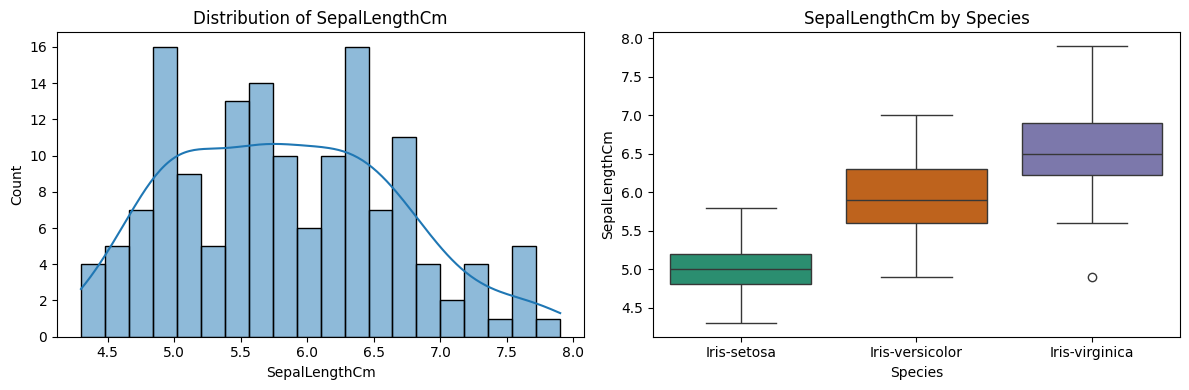

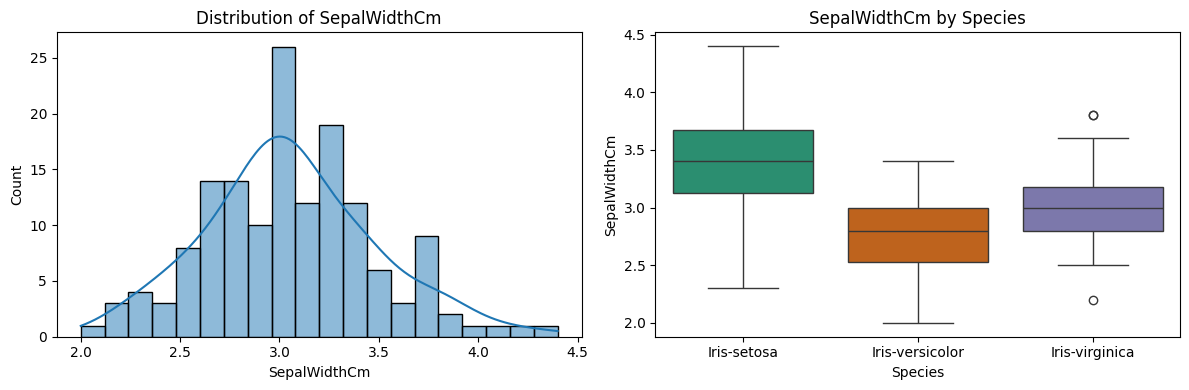

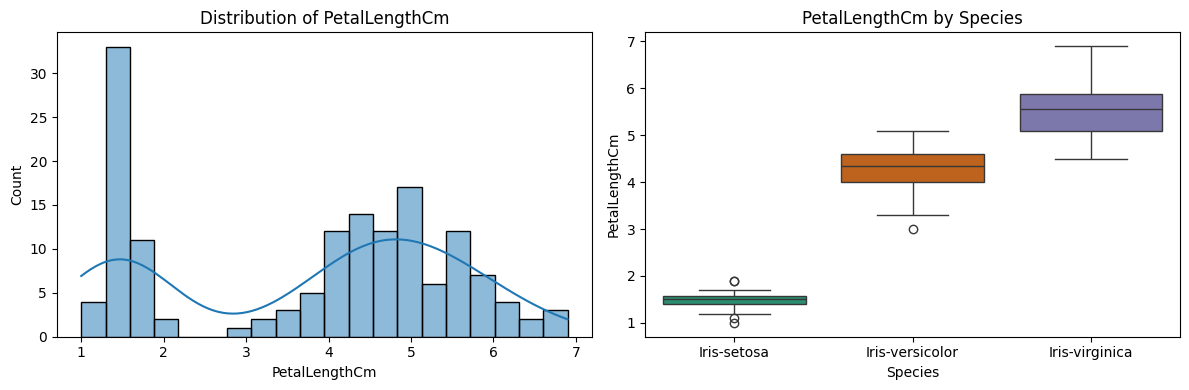

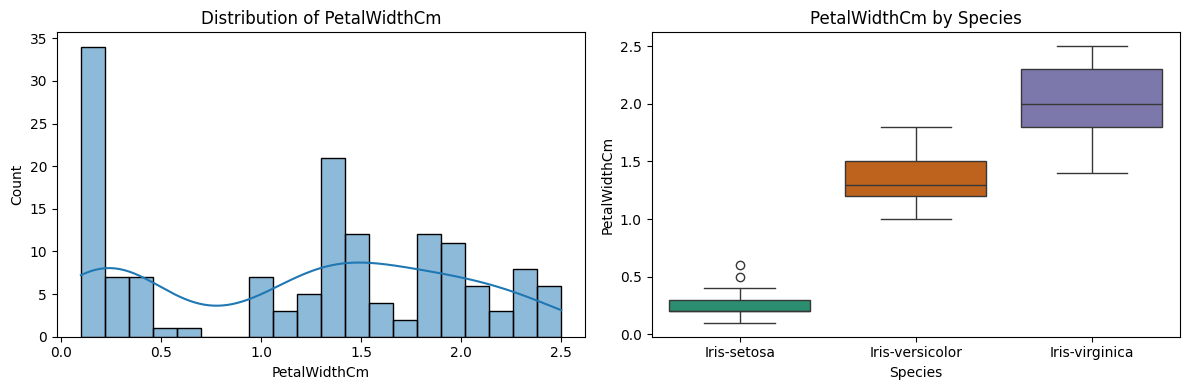

In [7]:
# Show variable distributions
show_distributions(df, "Species")

The boxplots suggest there may be outliers in all four variables. Check for outliers using the interquartile range (IQR) method and assess the impact of removing any outliers found: there are only 150 data points in this dataset.

In [9]:
# Identify outliers
outliers_ls = outliers_by_IQR(df, "Species")

0 outliers found in SepalLengthCm.
4 outliers found in SepalWidthCm.
0 outliers found in PetalLengthCm.
0 outliers found in PetalWidthCm.


In [10]:
# View outlier data points
outliers_ls

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
15,5.7,4.4,1.5,0.4,Iris-setosa
32,5.2,4.1,1.5,0.1,Iris-setosa
33,5.5,4.2,1.4,0.2,Iris-setosa
60,5.0,2.0,3.5,1.0,Iris-versicolor


There are four outliers. This is a sufficiently small number to simply drop these rows from the dataset.

In [11]:
# Obtain indices of outliers in a list
outlier_index = outliers_ls.index.tolist()

# Drop these rows
df.drop(outlier_index, inplace=True)

In [12]:
# Obtain summary statistics
print(df.describe().round(2))

       SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count         146.00        146.00         146.00        146.00
mean            5.86          3.04           3.81          1.22
std             0.83          0.40           1.76          0.76
min             4.30          2.20           1.00          0.10
25%             5.10          2.80           1.60          0.30
50%             5.80          3.00           4.40          1.30
75%             6.40          3.30           5.10          1.80
max             7.90          4.00           6.90          2.50


Text(0.5, 1.0, 'Distribution of Species')

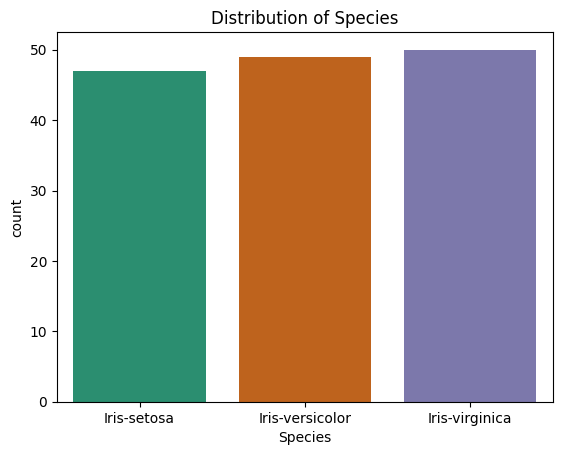

In [13]:
# Plot the distribution of the target variable to check the dataset is balanced.
# Prepare the figure
fig = plt.figure()

# Create plot
sns.countplot(
    x="Species", data=df, hue="Species", legend=False, palette='Dark2'
)

# Add title
plt.title("Distribution of Species")

The target variable is balanced.

### Correlation analysis

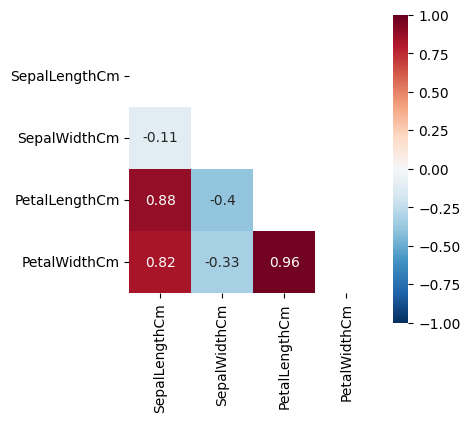

In [15]:
corr_df = heatmap(df, 4, 4)

The heatmap shows strong positive correlations between SepalLengthCm, PetalLengthCm and PetalLengthCm, consistent with larger flowers having larger component dimensions. There is a negative correlation between SepalWidthCm, PetalLengthCm and PetalWidthCm, indicating that as petals become larger, the sepal width gets narrower. The pairgrid below shows these relationships in more detail.

<Figure size 1000x1000 with 0 Axes>

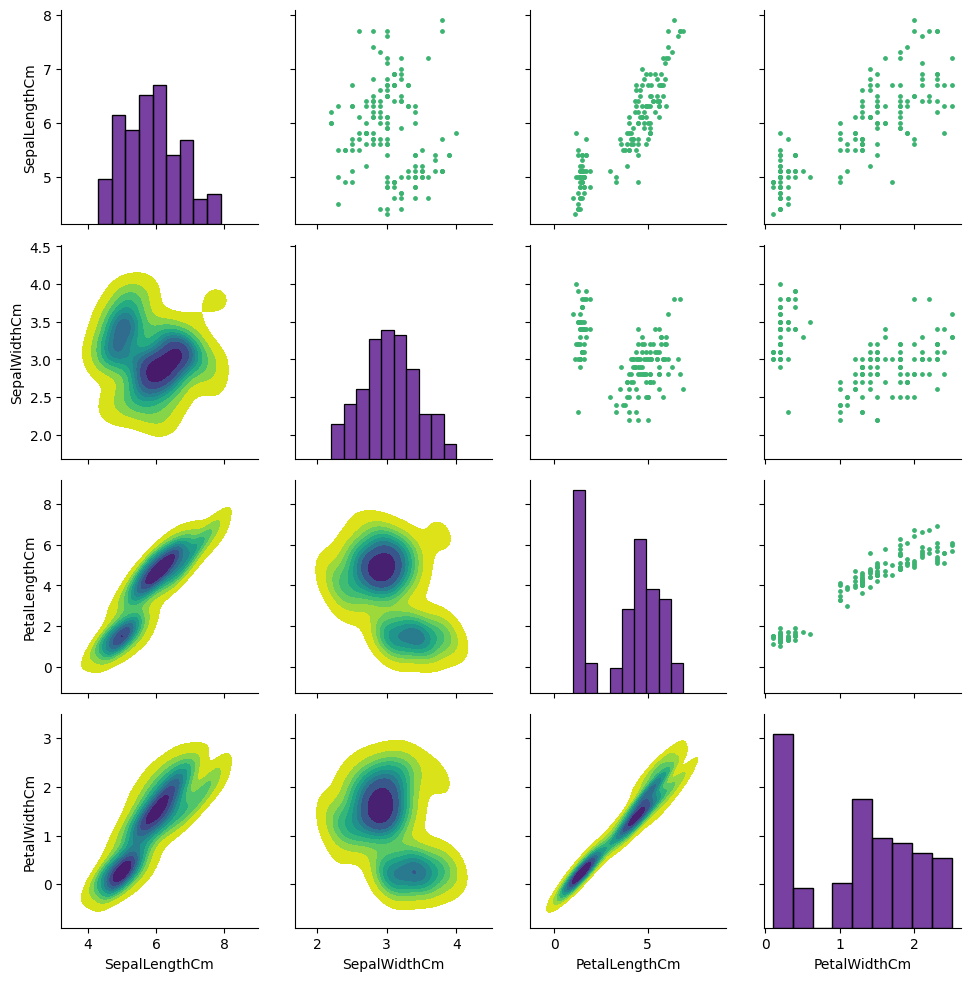

In [17]:
pairgrid(df)

The KDE plots show two islands, or population centres, in the dataset. A successful Principal Component Analysis should identify these two islands and reduce the data to two dimensions which can be visualised easily.

### Scale the data for PCA
Principal Component Analysis (PCA) requires the data are scaled and assumes the variables are all normally distributed. This means StandardScaler() the most appropriate scaling method to use.

In [18]:
# Prepare scaler
scaler = StandardScaler()

# Drop the output variable from the dataframe
X = df.drop(columns=["Species"], axis=1).copy()

# Scale data
X_scaled = scaler.fit_transform(X)

# Convert scaled data to dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns=[X.columns.tolist()])

### Principal Component Analysis with n_components = 3
Principal Component Analysis reduces the dimensionality of a dataset while retaining most of the information in the original data. This approach often improves model performance and is less subjective than eliminating variables by inspection. Also, performing PCA will often make visualisation of the dataset easier, although the combinations of variables within the components need to be part of the considerations when the results are interpreted.

In [19]:
# Prepare for PCA
pca = PCA(n_components=3)

# Perform PCA on scaled data
X_pca_array = pca.fit_transform(X_scaled)

### Generate the biplot

A biplot combines two data visualisations:
* scatter plot of scores
* vector diagram of the eigenvectors for each feature.

The scatter plot of scores shows the data points projected onto two PCA components. This allows high-dimension datasets to be visualised, potentially revealling relationships or structures within the data.

The vector diagram shows the relationship between the original features and the PCA components. 

In [21]:
# Convert scores to dataframe
X_pca = pd.DataFrame(X_pca_array, columns=['PC'+str(i) for i in range(1, 4)])

# Convert coefficients to dataframe
pca_coeffs = pd.DataFrame(
    pca.components_, columns=X.columns, index=X_pca.columns
)

SepalLengthCm   0.5280181768772633   0.3413934911438209
arrow
SepalWidthCm   -0.25089529462845483   0.9368051094120815
arrow
PetalLengthCm   0.5818153461335545   0.02340314695096411
arrow
PetalWidthCm   0.5654549133432336   0.07279398255929015
arrow


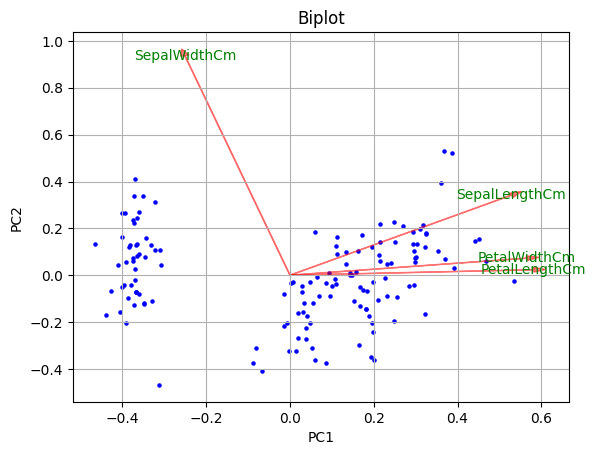

In [25]:
# Create biplot
biplot(X_pca, pca_coeffs)

The datapoints form a single cluster.

The eigenvectors for PetalLengthCm and PetalWidthCm are very closely aligned, indicating a strong relationship between them. In contrast, SepalLengthCm and SepalWidthCm have distinct orientations.

From this biplot, the three principal components in the data are SepalLengthCm, SepalWidthCm and PetalWidthCm.

### Hierarchical clustering

In [23]:
# Cluster data using hierarchical approach
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hc_model = model.fit(X_pca)

Plot dendrograms to compare the effect of the different approaches to linkage.

Text(0.5, 1.0, 'Complete')

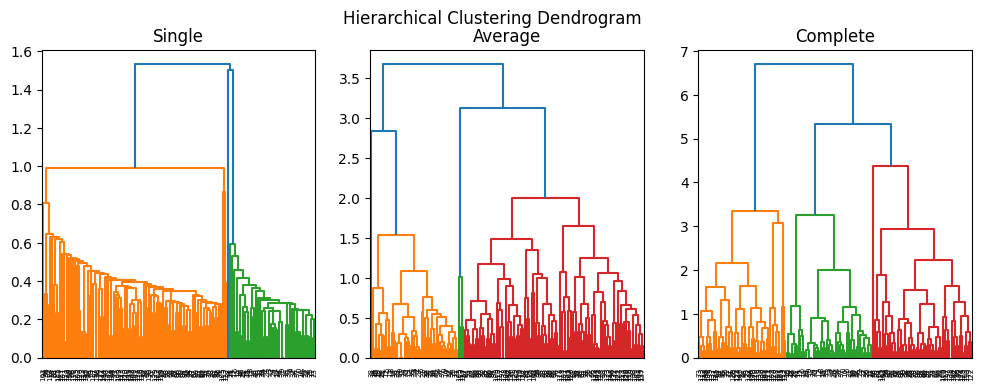

In [24]:
# Prepare figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4))

# Plot dendrograms
dendrogram(linkage(X_pca, method='single'), labels=X_pca.index, ax=ax1)
dendrogram(linkage(X_pca, method='average'), labels=X_pca.index, ax=ax2)
dendrogram(linkage(X_pca, method='complete'), labels=X_pca.index, ax=ax3)

# Add titles
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
ax2.set_title("Average")
ax3.set_title("Complete")

Complete linkage produces the most balanced dendrogram, reflecting the balanced nature of the original dataset.

Text(0.5, 1.0, 'Complete linkage')

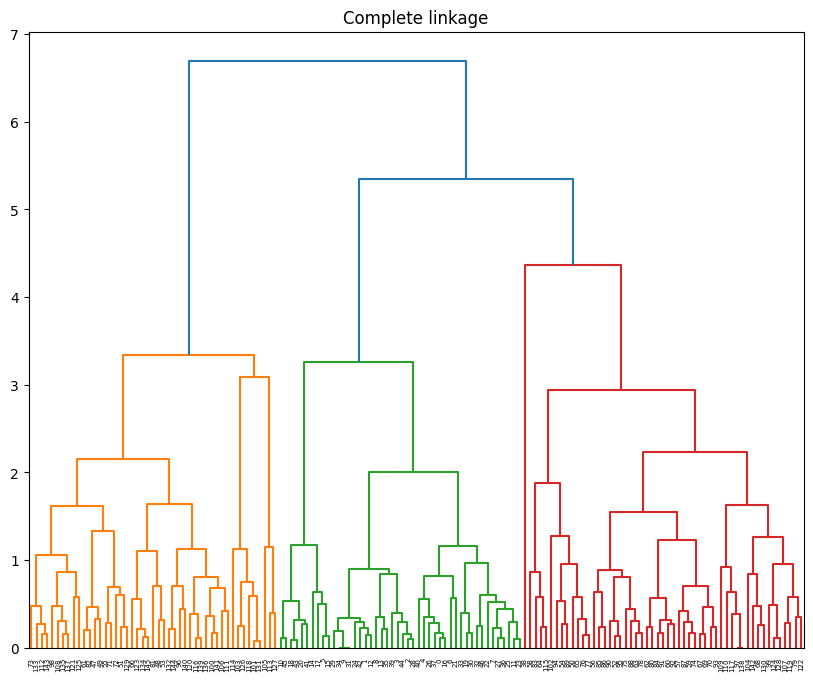

In [25]:
# Plot complete linkage dendrogram
# Prepare the figure
fig = plt.figure(figsize=(10,8))

# Plot the dendrogram
dendrogram(linkage(X_pca, method='complete'), labels=X_pca.index)

# Add title
plt.title("Complete linkage")

### K-means clustering

In [26]:
# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

In [27]:
# Add cluster labels
X_scaled_df["Cluster"] = cluster_labels

In [28]:
# Prepare LabelEncoder()
le = LabelEncoder()

# Apply le
label_array = le.fit_transform(df["Species"])

# Append label_array as a Species column in X_scaled_df
X_scaled_df["Species"] = label_array

# Remove accidentally created multi-index to prevent "Grouper for {var} not 
# 1-dimensional" ValueError.
X_scaled_df.columns = X_scaled_df.columns.get_level_values(0)

In [29]:
X_scaled_df.sample(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Cluster,Species
26,-0.790212,1.175789,-1.317771,-1.345899,2,0
17,-0.188695,1.937617,-1.203556,-1.213930,2,0
122,0.412822,-0.601809,0.566771,0.765598,0,2
109,-0.188695,-1.363637,0.680985,1.029536,0,2
47,1.375249,0.413961,0.509663,0.237724,1,1
14,-0.068392,2.445502,-1.489093,-1.345899,2,0
85,-0.429302,-1.363637,0.109912,0.105756,0,1
71,0.894035,-0.093924,0.338341,0.237724,1,1
40,-1.030819,1.175789,-1.260664,-0.818024,2,0
66,0.051912,0.413961,0.566771,0.765598,1,1


Grouped by cluster from K-means


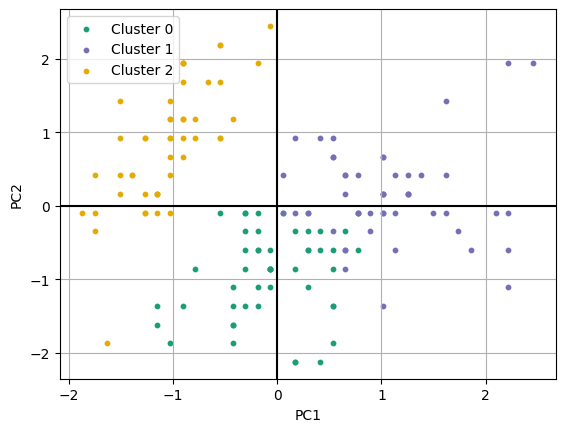

In [31]:
print("Grouped by cluster from K-means")
cluster_plot(df=X_scaled_df, groupby="Cluster", k=3)

Grouped by species from the target variable


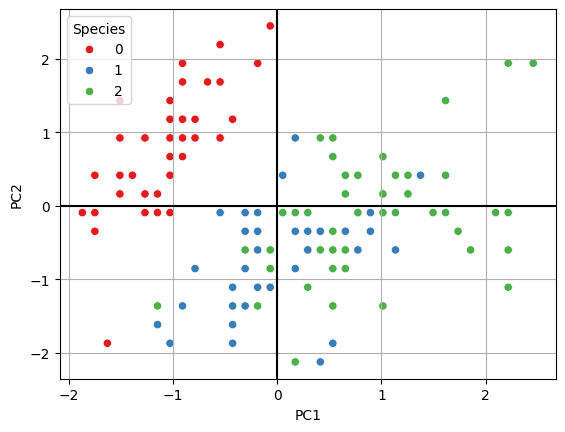

In [32]:
print("Grouped by species from the target variable")
# Prepare plot
fig = plt.figure()

# Create plot
sns.scatterplot(
    data=X_scaled_df, x=X_scaled[:,0], y=X_scaled[:,1], 
    hue="Species", palette="Set1"
)

# Add labels and legend
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Species")

# Add grid
plt.grid()
plt.axhline(0, color='black')
plt.axvline(0, color='black')

The K-means clusters do not correspond to the species labels from the original data. The clustering techniques have not identified the three species.

### Correlation analysis with the transformed data

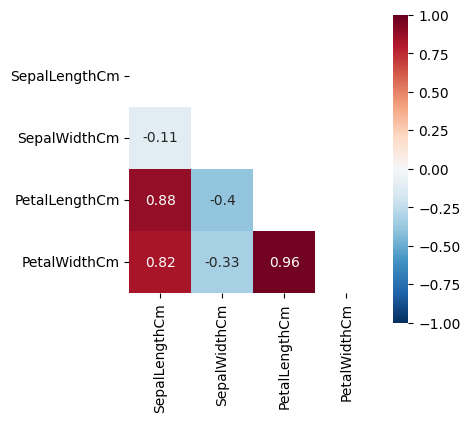

In [33]:
# Copy of the original heatmap.
corr_df = heatmap(df, 4, 4)

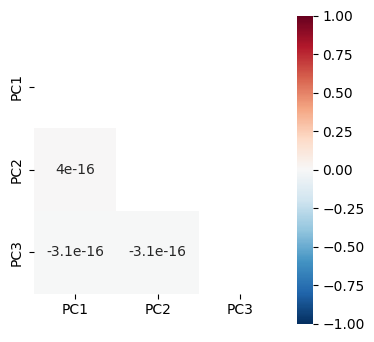

In [34]:
# Heatmap from the transformed data
corr_pca = heatmap(X_pca, 4, 4)

The heatmap form the transformed data (ie after PCA) shows only null relationships. This indicates the new variables from PCA are independent.

<Figure size 1000x1000 with 0 Axes>

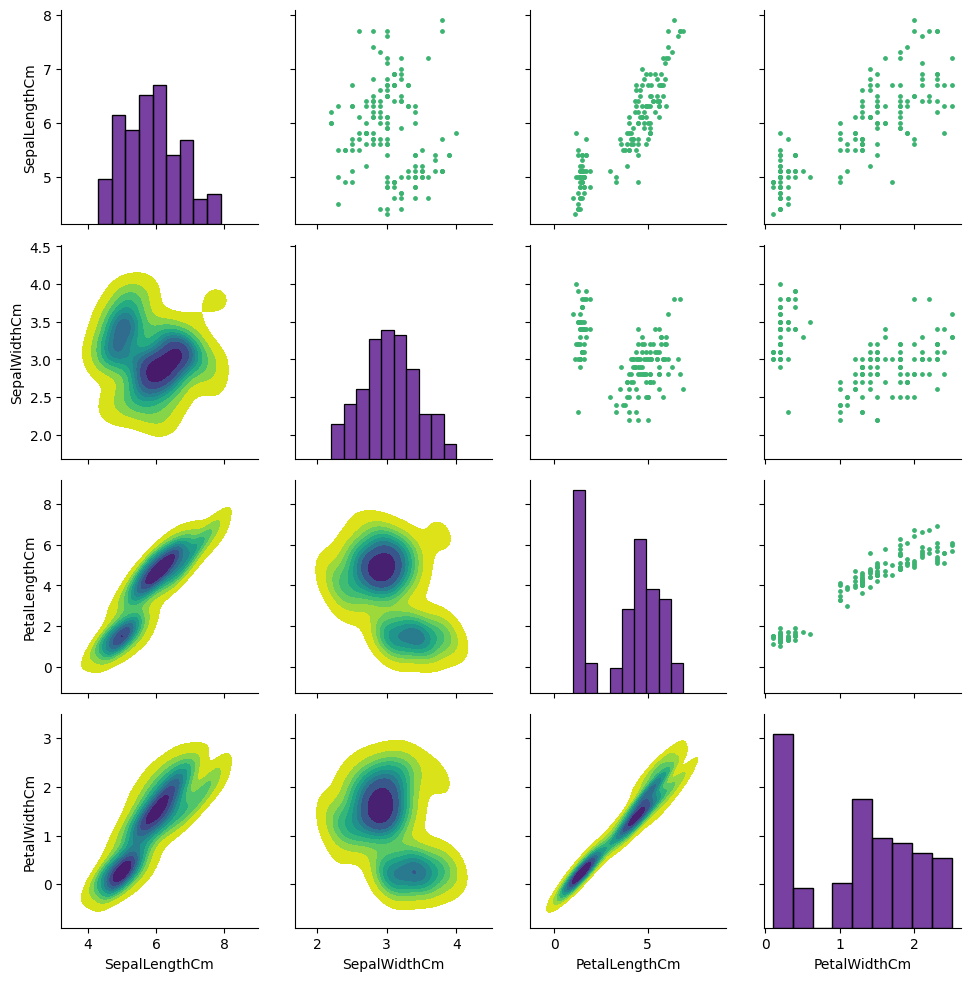

In [38]:
# Copy of the pairgrid
pairgrid(df)

<Figure size 1000x1000 with 0 Axes>

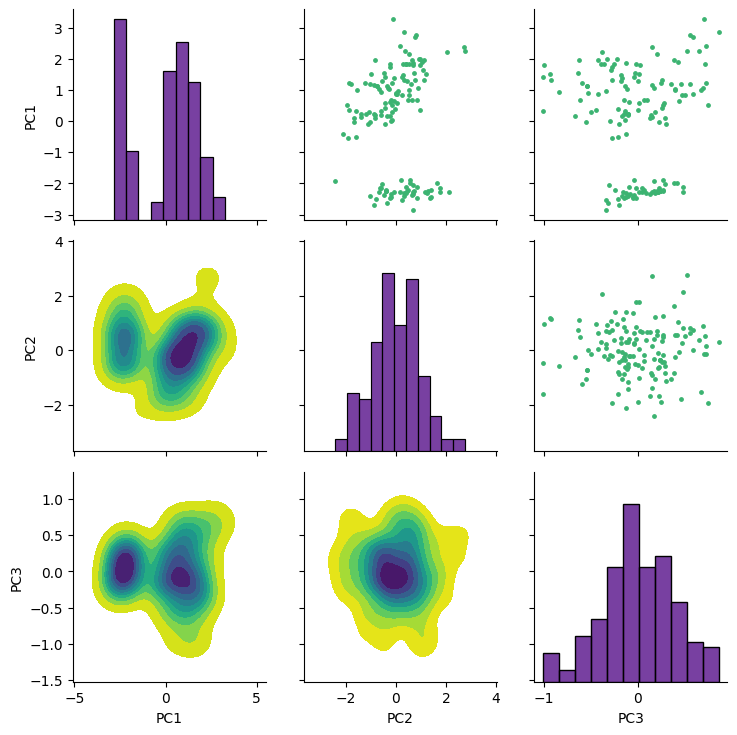

In [39]:
# Pairgrid from the transformed data
pairgrid(X_pca)

The pairgrid of the transformed (after PCA) data retains the bimodal distribution of PC1, which follows from the original distributions of petal length and width. The correlations between variables, including the two modes of PC1, are null.